## Steps
#### Data Wrangling

- Reads CSV files and assigns them to respective DataFrames using `pd.read_csv`.
- Converts the 'Date' column in the DataFrames to datetime format using `pd.to_datetime`.
- Modifies column names and manipulates the DataFrames.

#### Fetching additional financial data

- Uses the `yfinance` library to download historical market data for different assets.

#### Merging datasets

- Merges the individual DataFrames into a single DataFrame called `merged_data` using `pd.merge`.
- Now the `X=relative assets price(Gold, SPY, etc..) + Fundamentals（Supply and Demand, Default Prob, Region diff, Weather, etc..) + WTI techinical indicators(RSI, MACD, SMA, EMA)`, `y= WTI Close Price`
- 99 features in total

#### Feature Selection

- Using RFR to calculate features importance to help filter out features.

#### Data cleaning and preprocessing

- Handles missing values by filling them using forward-fill and back-fill methods.
- Performs feature engineering and preprocessing tasks on the data.

#### Principal Component Analysis (PCA)

- Applies PCA to reduce the dimensionality of the data.

#### Model building

- Splits the data into train and test sets using `train_test_split`.
- Builds machine learning models such as Random Forest, Gradient Boosting, LSTM, SVM, and Linear Regression.
- Hyperparameter tuning is performed using `GridSearchCV`.
- Evaluates the models using various metrics such as RMSE, MAE, and explained variance score.

#### Additional calculations and analysis

- Calculates additional metrics such as MAE and explained variance score for each model using cross-validation.
- Then calculates sharpe ratio based on the best performance strategy.


In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf


# Data Wrangling


In [71]:
df_uso = pd.read_csv("uso.csv", index_col=0)
df_rig = pd.read_csv("rig.csv", index_col=0)
df_energy_production = pd.read_csv("energy_production.csv", index_col=0)
df_default_probability = pd.read_csv("default_probability.csv", index_col=0)

In [72]:
# Convert the 'Date' column to datetime format
df_uso.index = pd.to_datetime(df_uso.index, dayfirst=True)
unique_tickers = df_uso['Ticker'].nunique()
unique_tickers

1

In [73]:
df_uso

,Ticker,Last Price,Bid Price,Ask Price,Low Price,High Price,Open Price,Volume
Date,,,,,,,,
2013-01-02,USO US Equity,270.56,270.64,270.72,269.600,272.72,272.00,693096
2013-01-03,USO US Equity,269.92,269.76,269.92,269.600,271.60,270.80,489416
2013-01-04,USO US Equity,271.04,271.04,271.12,268.560,271.12,269.60,742613
2013-01-07,USO US Equity,271.36,271.44,271.52,269.000,271.76,269.76,356665
2013-01-08,USO US Equity,271.68,271.20,271.36,269.840,272.24,272.08,480184
...,...,...,...,...,...,...,...,...
2023-05-15,USO US Equity,62.99,62.99,63.01,62.370,63.46,62.70,4837830
2023-05-16,USO US Equity,62.54,62.53,62.55,62.445,63.54,63.11,1992072
2023-05-17,USO US Equity,64.60,64.61,64.62,63.060,64.99,63.87,4275997


In [74]:
# Create a dictionary to store the new column names
new_columns = {}

# Iterate over the existing column names
for column in df_uso.columns:
    if column in ['Last Price', 'Volume']:
        new_columns[column] = 'USO' + '_' + df_uso['Ticker'].values[0] + '_' + column

# Rename the columns using the dictionary
df_uso.rename(columns=new_columns, inplace=True)

# Drop the columns other than 'Volume' and 'Close Price'
df_uso = df_uso[['USO_USO US Equity_Last Price', 'USO_USO US Equity_Volume']]

# Print the modified dataframe
df_uso.head()


,USO_USO US Equity_Last Price,USO_USO US Equity_Volume
Date,,
2013-01-02,270.56,693096
2013-01-03,269.92,489416
2013-01-04,271.04,742613
2013-01-07,271.36,356665
2013-01-08,271.68,480184


In [75]:

df_rig.index = pd.to_datetime(df_rig.index, dayfirst=True)
new_columns = {'US': 'rig_US',
               'Canada': 'rig_Canada',
               'Gulf of Mexico': 'rig_Gulf of Mexico',
               'North American': 'rig_North American'}

df_rig.rename(columns=new_columns, inplace=True)

df_rig.head()



,rig_US,rig_Canada,rig_Gulf of Mexico,rig_North American
Date,,,,
2013-01-04,1762,258,48,2020
2013-01-11,1761,531,50,2292
2013-01-18,1749,601,48,2350
2013-01-25,1753,621,51,2374
2013-02-01,1764,625,51,2389


In [76]:
df_energy_production

,Year,Quarter,Region,Type,Quantity
Index,,,,,
OMRSD001 Q012013 Index,2013,1,Total Demand,Demand,90.79
OMRSD001 Q022013 Index,2013,2,Total Demand,Demand,91.54
OMRSD001 Q032013 Index,2013,3,Total Demand,Demand,92.65
OMRSD001 Q042013 Index,2013,4,Total Demand,Demand,93.03
OMRSD001 Q012014 Index,2014,1,Total Demand,Demand,92.49
...,...,...,...,...,...
OMRST6M1 Q042021 Index,2021,4,Total Stock Chg & Misc,Stock Changes and Miscellaneous Reported OECD,-2.89
OMRST6M1 Q012022 Index,2022,1,Total Stock Chg & Misc,Stock Changes and Miscellaneous Reported OECD,-0.85
OMRST6M1 Q022022 Index,2022,2,Total Stock Chg & Misc,Stock Changes and Miscellaneous Reported OECD,-0.04


In [77]:
df_energy_production['Quarter_end'] = df_energy_production['Quarter']*3


In [78]:
df_energy_production['Date'] = pd.to_datetime(df_energy_production['Year'].astype(str) + df_energy_production['Quarter_end'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(1)
df_energy_production['Date'] = df_energy_production['Date'].dt.strftime('%m/%d/%Y')
df_energy_production.set_index('Date', inplace=True)
df_energy_production.sort_index(inplace=True)
df_energy_production.drop('Quarter_end', axis=1, inplace=True)
df_energy_production

,Year,Quarter,Region,Type,Quantity
Date,,,,,
03/31/2013,2013,1,Total Demand,Demand,90.79
03/31/2013,2013,1,NGLs,Supply,6.31
03/31/2013,2013,1,Crude,Supply,31.44
03/31/2013,2013,1,Total OPEC,Supply,37.74
03/31/2013,2013,1,Total Non-OPEC,Supply,52.65
...,...,...,...,...,...
12/31/2022,2022,4,Other Asia,Supply,2.70
12/31/2022,2022,4,China,Supply,4.13
12/31/2022,2022,4,Europe,Supply,0.10


In [79]:
# Create a new column that combines 'Region' and 'Type'
df_energy_production['Region_Type'] = df_energy_production['Region'] + "_" + df_energy_production['Type']

# Pivot on 'Date', 'Region_Type' and 'Quantity'
df_energy_production_pivot = df_energy_production.pivot_table(index='Date', columns='Region_Type', values='Quantity')

# If you want to fill NA/NaN values with 0
df_energy_production_pivot.fillna(0, inplace=True)
df_energy_production_pivot
# Convert index back to datetime
df_energy_production_pivot.index = pd.to_datetime(df_energy_production_pivot.index, format='%m/%d/%Y')

# Sort DataFrame by index
df_energy_production_pivot.sort_index(inplace=True)
df_energy_production_pivot


Region_Type,Africa_Demand,Africa_Supply,Americas_Demand,Americas_Supply,China_Demand,China_Supply,Crude_Supply,Europe_Demand,Europe_Supply,FSU_Demand,...,Other Asia_Supply,Pacific_Demand,Pacific_Supply,Processing Gains_Supply,Total (Govt + Industry)_Stock Changes and Miscellaneous Reported OECD,Total Demand_Demand,Total Non-OPEC_Supply,Total OPEC_Supply,Total Stock Chg & Misc_Stock Changes and Miscellaneous Reported OECD,Total Supply_Supply
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,3.94,1.92,23.86,16.75,10.20,4.20,31.44,6.865,1.765,4.43,...,2.74,8.83,0.44,2.18,4615.00,90.79,52.65,37.74,-0.39,90.40
2013-06-30,3.90,1.99,23.93,16.71,10.31,4.23,31.89,7.240,1.725,4.63,...,2.68,7.87,0.49,2.16,4554.00,91.54,53.10,38.22,-0.23,91.31
2013-09-30,3.64,2.00,24.39,17.41,10.35,4.07,31.57,7.310,1.665,4.97,...,2.60,8.02,0.51,2.20,4428.00,92.65,53.88,37.92,-0.85,91.80
2013-12-31,3.83,2.13,24.41,17.82,10.59,4.24,30.77,7.115,1.760,4.98,...,2.64,8.62,0.45,2.18,4398.00,93.03,54.78,37.07,-1.18,91.85
2014-03-31,3.93,2.09,23.94,18.26,10.64,4.22,30.93,6.860,1.820,4.64,...,2.67,8.87,0.50,2.21,4392.00,92.49,54.90,37.34,-0.25,92.24
2014-06-30,3.87,2.06,23.78,18.89,10.71,4.24,31.01,7.060,1.685,4.88,...,2.63,7.63,0.51,2.19,4439.00,92.53,55.69,37.45,0.61,93.15
2014-09-30,3.72,2.05,24.43,19.28,10.58,4.18,31.46,7.300,1.630,5.14,...,2.58,7.64,0.52,2.24,4426.00,93.48,56.35,38.01,0.88,94.36
2014-12-31,3.79,2.07,24.62,19.90,11.17,4.35,31.44,7.095,1.795,5.03,...,2.73,8.28,0.49,2.22,4317.80,94.27,57.56,38.03,1.33,95.59
2015-03-31,4.09,2.07,24.34,19.99,11.24,4.28,31.42,7.055,1.780,4.67,...,2.79,8.67,0.42,2.24,4396.60,93.76,57.18,38.09,1.50,95.26


In [80]:
df_default_probability
# Convert the 'Date' column to datetime format
df_default_probability.index = pd.to_datetime(df_default_probability.index, dayfirst=True)

df_default_probability.head()


,Equity,Ticker,BB_3M_DEFAULT_PROB,BB_6M_DEFAULT_PROB,BB_9M_DEFAULT_PROB,BB_1YR_DEFAULT_PROB
Date,,,,,,
2013-01-02,China Petroleum & Chemical Ord Shs A,386 HK Equity,0.0,1.100000e-08,3.750000e-07,0.000004
2013-01-03,China Petroleum & Chemical Ord Shs A,387 HK Equity,0.0,1.100000e-08,3.710000e-07,0.000004
2013-01-04,China Petroleum & Chemical Ord Shs A,388 HK Equity,0.0,4.600000e-08,1.100000e-06,0.000009
2013-01-07,China Petroleum & Chemical Ord Shs A,389 HK Equity,0.0,3.600000e-08,9.130000e-07,0.000008
2013-01-08,China Petroleum & Chemical Ord Shs A,390 HK Equity,0.0,3.400000e-08,8.790000e-07,0.000007


In [81]:
# Drop the 'Ticker' column
df_default_probability_pivot = df_default_probability.drop('Ticker', axis=1)

# Pivot the dataframe
df_default_probability_pivot = df_default_probability_pivot.pivot(columns='Equity', values=['BB_3M_DEFAULT_PROB', 'BB_6M_DEFAULT_PROB', 'BB_9M_DEFAULT_PROB', 'BB_1YR_DEFAULT_PROB'])

# Flatten the column names by joining the equity name and default probability type
df_default_probability_pivot.columns = [f'{col[1]}_{col[0]}' for col in df_default_probability_pivot.columns]

# Reset the index
df_default_probability_pivot.sort_values(by='Date', inplace=True)

df_default_probability_pivot.head()



,Chevron Corporation_BB_3M_DEFAULT_PROB,China Petroleum & Chemical Ord Shs A_BB_3M_DEFAULT_PROB,Exxon Mobil Corp_BB_3M_DEFAULT_PROB,Saudi Arabian Oil Co_BB_3M_DEFAULT_PROB,Shell PLC_BB_3M_DEFAULT_PROB,Chevron Corporation_BB_6M_DEFAULT_PROB,China Petroleum & Chemical Ord Shs A_BB_6M_DEFAULT_PROB,Exxon Mobil Corp_BB_6M_DEFAULT_PROB,Saudi Arabian Oil Co_BB_6M_DEFAULT_PROB,Shell PLC_BB_6M_DEFAULT_PROB,Chevron Corporation_BB_9M_DEFAULT_PROB,China Petroleum & Chemical Ord Shs A_BB_9M_DEFAULT_PROB,Exxon Mobil Corp_BB_9M_DEFAULT_PROB,Saudi Arabian Oil Co_BB_9M_DEFAULT_PROB,Shell PLC_BB_9M_DEFAULT_PROB,Chevron Corporation_BB_1YR_DEFAULT_PROB,China Petroleum & Chemical Ord Shs A_BB_1YR_DEFAULT_PROB,Exxon Mobil Corp_BB_1YR_DEFAULT_PROB,Saudi Arabian Oil Co_BB_1YR_DEFAULT_PROB,Shell PLC_BB_1YR_DEFAULT_PROB
Date,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,0.0,0.0,NaN,0.0,0.0,1.100000e-08,0.0,NaN,9.000000e-09,4.000000e-09,3.750000e-07,2.000000e-09,NaN,3.610000e-07,1.230000e-07,0.000004,6.800000e-08,NaN,0.000004
2013-01-03,0.0,0.0,0.0,NaN,0.0,0.0,1.100000e-08,0.0,NaN,9.000000e-09,4.000000e-09,3.710000e-07,2.000000e-09,NaN,3.540000e-07,1.260000e-07,0.000004,6.800000e-08,NaN,0.000004
2013-01-04,0.0,0.0,0.0,NaN,0.0,0.0,4.600000e-08,0.0,NaN,8.000000e-09,4.000000e-09,1.100000e-06,2.000000e-09,NaN,3.260000e-07,1.210000e-07,0.000009,6.700000e-08,NaN,0.000004
2013-01-07,0.0,0.0,0.0,NaN,0.0,0.0,3.600000e-08,0.0,NaN,8.000000e-09,4.000000e-09,9.130000e-07,2.000000e-09,NaN,3.310000e-07,1.250000e-07,0.000008,7.400000e-08,NaN,0.000004
2013-01-08,0.0,0.0,0.0,NaN,0.0,0.0,3.400000e-08,0.0,NaN,9.000000e-09,4.000000e-09,8.790000e-07,2.000000e-09,NaN,3.390000e-07,1.250000e-07,0.000007,7.100000e-08,NaN,0.000004


In [82]:
dxy = yf.Ticker("DX-Y.NYB")

# get historical market data
df_dxy = pd.DataFrame(dxy.history(start="2013-01-02", end="2023-05-25"))
df_dxy = df_dxy[['Close','Volume']]
df_dxy = df_dxy.rename(columns={'Close': 'dxy_close','Volume':'dxy_volume'})

df_dxy.head()

,dxy_close,dxy_volume
Date,,
2013-01-02,79.849998,0
2013-01-03,80.430000,0
2013-01-04,80.500000,0
2013-01-07,80.260002,0
2013-01-08,80.349998,0


In [83]:
ten_year_bond = yf.Ticker("^TNX")

# get historical market data
df_TNX = pd.DataFrame(ten_year_bond.history(start="2013-01-02", end="2023-05-25"))
df_TNX = df_TNX[['Close','Volume']]
df_TNX = df_TNX.rename(columns={'Close': 'tnx_close','Volume':'tnx_volume'})
df_TNX.head()

,tnx_close,tnx_volume
Date,,
2013-01-02,1.839,0
2013-01-03,1.899,0
2013-01-04,1.915,0
2013-01-07,1.903,0
2013-01-08,1.871,0


In [84]:
import nasdaqdatalink

myapikey = "Z2FwgtuL8zaZTgfNS8mg"
sdate = '2013-01-02'
edate = '2023-05-25'
df_CFTC = nasdaqdatalink.get(f'CFTC/067651_F_ALL', start_date = sdate, end_date = edate, api_key = myapikey)
df_CFTC.to_csv('CFTC_067651_F_ALL.csv')
df_CFTC

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2013-01-08,1477695.0,243476.0,258128.0,154641.0,358375.0,176504.0,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
2013-01-15,1495149.0,247259.0,256475.0,141683.0,372083.0,175788.0,209693.0,37007.0,254296.0,144437.0,90372.0,238941.0,1412097.0,1424962.0,83052.0,70187.0
2013-01-22,1491867.0,236622.0,240834.0,131122.0,379319.0,168406.0,228075.0,30667.0,257452.0,138409.0,89714.0,250697.0,1410783.0,1417089.0,81084.0,74778.0
2013-01-29,1553636.0,247065.0,252167.0,125014.0,395643.0,168655.0,232827.0,25773.0,280007.0,146077.0,85142.0,274252.0,1473897.0,1481639.0,79739.0,71997.0
2013-02-05,1594844.0,264415.0,263546.0,123287.0,405144.0,183538.0,227589.0,25756.0,284160.0,152474.0,87503.0,276164.0,1511627.0,1525811.0,83217.0,69033.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,1826195.0,497975.0,509700.0,80168.0,339640.0,96066.0,215016.0,40926.0,513192.0,108815.0,46467.0,228144.0,1739376.0,1774135.0,86819.0,52060.0
2023-05-02,1908299.0,549363.0,561327.0,84866.0,325807.0,103309.0,188610.0,56779.0,523990.0,135127.0,52113.0,230853.0,1816118.0,1854178.0,92181.0,54121.0
2023-05-09,1885886.0,563469.0,561221.0,84884.0,326588.0,105541.0,209337.0,62081.0,493800.0,128818.0,59446.0,215316.0,1801165.0,1823993.0,84721.0,61893.0


In [85]:
import yfinance as yf

dju = yf.Ticker("^DJU")

# get historical market data
df_dju = pd.DataFrame(dju.history(start="2013-01-02", end="2023-05-23"))
df_dju = df_dju[['Close','Volume']]
df_dju = df_dju.rename(columns={'Close': 'dju_close','Volume':'dju_volume'})
df_dju.tail()

,dju_close,dju_volume
Date,,
2023-05-16,923.489990,44950000
2023-05-17,921.270020,45920000
2023-05-18,916.909973,48520000
2023-05-19,914.830017,51770000
2023-05-22,915.929993,36880000


In [86]:
# Merge the datasets one by one
merged_data = df_uso.merge(df_rig, how='outer', on='Date')
merged_data = merged_data.merge(df_energy_production_pivot, how='outer', on='Date')
merged_data = merged_data.merge(df_default_probability_pivot, how='outer', on='Date')
merged_data = merged_data.merge(df_CFTC, how='outer', on='Date')

# Sort the merged dataset by date
merged_data.sort_values('Date', inplace=True)

# Print the merged dataset
merged_data

,USO_USO US Equity_Last Price,USO_USO US Equity_Volume,rig_US,rig_Canada,rig_Gulf of Mexico,rig_North American,Africa_Demand,Africa_Supply,Americas_Demand,Americas_Supply,...,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,270.56,693096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,269.92,489416.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,271.04,742613.0,1762.0,258.0,48.0,2020.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,271.36,356665.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,271.68,480184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,62.54,1992072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0
2023-05-17,64.60,4275997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-18,64.04,2496649.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# Count missing values in each column
missing_counts = merged_data.isnull().sum()

# Print the result
print(missing_counts)

USO_USO US Equity_Last Price     299
USO_USO US Equity_Volume         299
rig_US                          2371
rig_Canada                      2371
rig_Gulf of Mexico              2371
                                ... 
Other Reportable Spreads        2371
Total Reportable Longs          2371
Total Reportable Shorts         2371
Non Reportable Longs            2371
Non Reportable Shorts           2371
Length: 78, dtype: int64


In [88]:
# Forward-fill missing values
merged_data_filled = merged_data.fillna(method='ffill')

# Back-fill remaining missing values
merged_data_filled = merged_data_filled.fillna(method='bfill')
merged_data_filled

,USO_USO US Equity_Last Price,USO_USO US Equity_Volume,rig_US,rig_Canada,rig_Gulf of Mexico,rig_North American,Africa_Demand,Africa_Supply,Americas_Demand,Americas_Supply,...,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,270.56,693096.0,1762.0,258.0,48.0,2020.0,3.94,1.92,23.86,16.75,...,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
2013-01-03,269.92,489416.0,1762.0,258.0,48.0,2020.0,3.94,1.92,23.86,16.75,...,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
2013-01-04,271.04,742613.0,1762.0,258.0,48.0,2020.0,3.94,1.92,23.86,16.75,...,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
2013-01-07,271.36,356665.0,1762.0,258.0,48.0,2020.0,3.94,1.92,23.86,16.75,...,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
2013-01-08,271.68,480184.0,1762.0,258.0,48.0,2020.0,3.94,1.92,23.86,16.75,...,202209.0,41045.0,241949.0,145651.0,92037.0,235608.0,1400038.0,1403646.0,77657.0,74049.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,62.54,1992072.0,731.0,94.0,22.0,825.0,4.29,1.29,24.95,26.26,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0
2023-05-17,64.60,4275997.0,731.0,94.0,22.0,825.0,4.29,1.29,24.95,26.26,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0
2023-05-18,64.04,2496649.0,731.0,94.0,22.0,825.0,4.29,1.29,24.95,26.26,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0


In [89]:
missing_counts = merged_data_filled.isnull().sum()
missing_counts.sort_values(ascending=False)

USO_USO US Equity_Last Price               0
Exxon Mobil Corp_BB_6M_DEFAULT_PROB        0
Shell PLC_BB_9M_DEFAULT_PROB               0
Saudi Arabian Oil Co_BB_9M_DEFAULT_PROB    0
Exxon Mobil Corp_BB_9M_DEFAULT_PROB        0
                                          ..
NGLs_Supply                                0
Middle East_Supply                         0
Middle East_Demand                         0
Latin America_Supply                       0
Non Reportable Shorts                      0
Length: 78, dtype: int64

In [90]:
merged_data_filled.to_csv('merged_data_filled.csv', index=True)

## Model building

In [91]:
import talib

In [92]:
wti = yf.download("CL=F", start="2013-01-01", end="2023-05-25")
wti = wti[['Close']]
wti.index = pd.to_datetime(wti.index)

# Create a new dataframe for SMAs
wti_ta = pd.DataFrame()

# Calculate SMAs
wti_ta['10SMA'] = wti['Close'].rolling(window=10).mean()
wti_ta['30SMA'] = wti['Close'].rolling(window=30).mean()
wti_ta['50SMA'] = wti['Close'].rolling(window=50).mean()
wti_ta['100SMA'] = wti['Close'].rolling(window=100).mean()
wti_ta['200SMA'] = wti['Close'].rolling(window=200).mean()
wti_ta['EMA(10)'] = talib.EMA(wti['Close'], timeperiod=10)
wti_ta['EMA(20)'] = talib.EMA(wti['Close'], timeperiod=20)
wti_ta['EMA(50)'] = talib.EMA(wti['Close'], timeperiod=50)
wti_ta['EMA(99)'] = talib.EMA(wti['Close'], timeperiod=99)
wti_ta['RSI(7)'] = talib.RSI(wti['Close'], timeperiod=7)
wti_ta['RSI(14)'] = talib.RSI(wti['Close'], timeperiod=14)
wti_ta['RSI(21)'] = talib.RSI(wti['Close'], timeperiod=21)
wti_ta['RSI(49)'] = talib.RSI(wti['Close'], timeperiod=49)




# Print the updated WTI_SMA dataframe
print(wti_ta.tail())

[*********************100%***********************]  1 of 1 completed
                10SMA      30SMA    50SMA   100SMA    200SMA    EMA(10)  \
Date                                                                      
2023-05-18  71.834000  75.680334  74.5898  76.1935  80.46900  71.976362   
2023-05-19  71.855001  75.375334  74.5064  76.1137  80.38405  71.898842   
2023-05-22  71.738000  75.117001  74.4126  76.0440  80.29895  71.915416   
2023-05-23  71.658001  74.829668  74.3748  75.9891  80.20970  72.096250   
2023-05-24  71.836001  74.532334  74.4350  75.9299  80.12890  72.504204   

              EMA(20)    EMA(50)    EMA(99)     RSI(7)    RSI(14)    RSI(21)  \
Date                                                                           
2023-05-18  73.076378  74.754681  76.641417  47.149276  44.982792  45.417921   
2023-05-19  72.931009  74.629007  76.539589  45.345138  44.216580  44.915781   
2023-05-22  72.841389  74.525517  76.448597  48.601842  45.632110  45.808688   
2023-

In [93]:
other_assets = ["SPY", "^VIX", "GC=F", "BZ=F","^DJU","^TNX","DX-Y.NYB"]
other_assets = yf.download(other_assets, start="2013-01-01", end="2023-05-25")
other_assets = pd.DataFrame(other_assets["Close"]).fillna(method="ffill")
other_assets

[*********************100%***********************]  7 of 7 completed


,BZ=F,DX-Y.NYB,GC=F,SPY,^DJU,^TNX,^VIX
Date,,,,,,,
2012-12-31,111.110001,79.769997,1674.800049,142.410004,453.089996,1.756,18.020000
2013-01-02,112.470001,79.849998,1687.900024,146.059998,461.459991,1.839,14.680000
2013-01-03,112.139999,80.430000,1673.699951,145.729996,461.570007,1.899,14.560000
2013-01-04,111.309998,80.500000,1648.099976,146.369995,464.619995,1.915,13.830000
2013-01-07,111.400002,80.260002,1645.500000,145.970001,459.369995,1.903,13.790000
...,...,...,...,...,...,...,...
2023-05-18,75.860001,103.580002,1956.500000,419.230011,916.909973,3.648,16.049999
2023-05-19,75.580002,103.199997,1978.699951,418.619995,914.830017,3.692,16.809999
2023-05-22,75.989998,103.199997,1974.800049,418.790009,915.929993,3.719,17.209999


In [173]:
fundamentals = merged_data_filled
corr = fundamentals.corr()
fundamentals.describe()

,USO_USO US Equity_Last Price,USO_USO US Equity_Volume,rig_US,rig_Canada,rig_Gulf of Mexico,rig_North American,Africa_Demand,Africa_Supply,Americas_Demand,Americas_Supply,...,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
count,2913.000000,2.913000e+03,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,...,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.00000,2.913000e+03,2.913000e+03,2913.000000,2913.000000
mean,115.639965,3.994993e+06,928.907655,192.800206,25.858908,1119.493649,4.078884,1.599804,24.542012,21.900285,...,308479.786474,71969.907312,405791.567800,231852.825609,84310.888088,249067.79643,1.868420e+06,1.887907e+06,92000.067971,72512.875386
std,81.081556,4.819275e+06,475.358757,122.822517,15.035798,571.515789,0.213140,0.296052,1.067245,2.916810,...,73900.536439,41230.074265,103762.674573,71728.960455,27010.289235,47161.50485,2.973110e+05,3.040272e+05,12435.258962,15553.881252
min,17.040000,1.149700e+05,244.000000,13.000000,0.000000,0.000000,3.470000,1.290000,20.000000,16.710000,...,174327.000000,14132.000000,230454.000000,97365.000000,18905.000000,159228.00000,1.311342e+06,1.328399e+06,64831.000000,42395.000000
25%,68.100000,1.979262e+06,579.000000,111.000000,16.000000,740.000000,3.930000,1.350000,24.340000,19.700000,...,253328.000000,42926.000000,315427.000000,164395.000000,64925.000000,218906.00000,1.619244e+06,1.620985e+06,81786.000000,58433.000000
50%,89.440000,3.188714e+06,806.000000,172.000000,20.000000,994.000000,4.120000,1.500000,24.770000,22.300000,...,297492.000000,61220.000000,397831.000000,242174.000000,83246.000000,241040.00000,1.904561e+06,1.923155e+06,91162.000000,73290.000000
75%,118.640000,4.846191e+06,1050.000000,222.000000,29.000000,1257.000000,4.270000,1.920000,25.150000,24.500000,...,360883.000000,89321.000000,493354.000000,286496.000000,99945.000000,273251.00000,2.070503e+06,2.092020e+06,101301.000000,84002.000000
max,314.880000,1.254070e+08,1931.000000,662.000000,63.000000,2423.000000,4.360000,2.130000,26.020000,26.260000,...,519545.000000,232202.000000,640487.000000,411581.000000,171883.000000,394821.00000,2.588458e+06,2.618389e+06,130273.000000,113960.000000


In [95]:
# Merge the dataframes
merged_data = pd.concat([wti,wti_ta, other_assets, fundamentals], axis=1)
merged_data.isnull().sum()

Close                       297
10SMA                       306
30SMA                       326
50SMA                       346
100SMA                      396
                           ... 
Other Reportable Spreads      3
Total Reportable Longs        3
Total Reportable Shorts       3
Non Reportable Longs          3
Non Reportable Shorts         3
Length: 99, dtype: int64

In [96]:
# Drop rows with NA values
merged_data.dropna(inplace=True)


In [97]:
# corr = merged_data.corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

## Feature Selections
### RFE

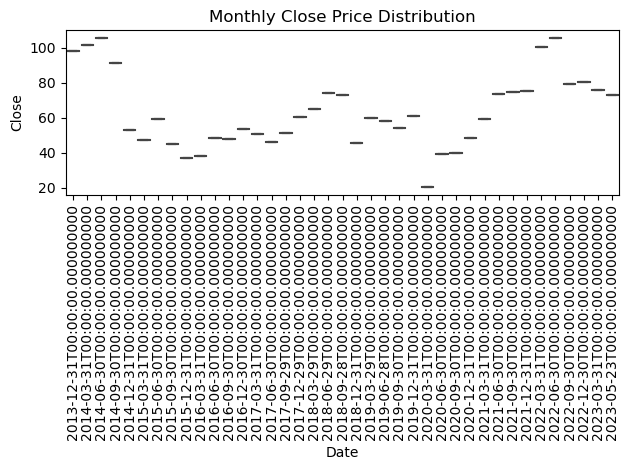

In [98]:
# Reset the index of merged_data
merged_data_reset = merged_data.reset_index()

# Convert 'Date' column to datetime type
merged_data_reset['Date'] = pd.to_datetime(merged_data_reset['Date'])

# Resample the data to monthly frequency
monthly_data = merged_data_reset.resample('Q', on='Date').last()

# Plot the box plot
sns.boxplot(x=monthly_data['Date'], y='Close', data=monthly_data)
plt.title('Monthly Close Price Distribution')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


In [99]:
merged_data

,Close,10SMA,30SMA,50SMA,100SMA,200SMA,EMA(10),EMA(20),EMA(50),EMA(99),...,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-15,101.209999,102.802999,104.874666,105.5450,102.8589,98.41285,102.562201,103.436380,104.215226,102.803201,...,261855.0,43338.0,391693.0,155059.0,70644.0,249523.0,1739072.0,1753525.0,85857.0,71404.0
2013-10-16,102.290001,102.621999,104.709999,105.4848,102.9403,98.46520,102.512710,103.327201,104.139727,102.792937,...,261855.0,43338.0,391693.0,155059.0,70644.0,249523.0,1739072.0,1753525.0,85857.0,71404.0
2013-10-17,100.669998,102.357999,104.453333,105.4108,102.9969,98.50295,102.177671,103.074134,104.003659,102.750478,...,261855.0,43338.0,391693.0,155059.0,70644.0,249523.0,1739072.0,1753525.0,85857.0,71404.0
2013-10-18,100.809998,102.055000,104.129332,105.3590,103.0737,98.54240,101.929003,102.858502,103.878417,102.711669,...,261855.0,43338.0,391693.0,155059.0,70644.0,249523.0,1739072.0,1753525.0,85857.0,71404.0
2013-10-21,99.220001,101.674000,103.785999,105.2240,103.1298,98.57305,101.436458,102.511978,103.695734,102.641835,...,261855.0,43338.0,391693.0,155059.0,70644.0,249523.0,1739072.0,1753525.0,85857.0,71404.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,70.860001,71.081000,76.234667,74.7808,76.3171,80.67095,71.818268,73.243830,74.956212,76.818772,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0
2023-05-17,72.830002,71.504000,75.972001,74.6858,76.2705,80.56300,72.002220,73.204418,74.872831,76.738997,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0
2023-05-18,71.860001,71.834000,75.680334,74.5898,76.1935,80.46900,71.976362,73.076378,74.754681,76.641417,...,209384.0,77714.0,495673.0,118587.0,58788.0,217922.0,1772202.0,1796345.0,84368.0,60225.0


In [100]:
y=merged_data['Close']
X = merged_data.drop("Close", axis=1)

In [176]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Create a Random Forest model
model = RandomForestRegressor()

# Train the model
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 50 features
top_feature_indices = sorted_indices[:50]
X_selected = X.iloc[:, top_feature_indices]

# Print feature importances
for i, feature_index in enumerate(top_feature_indices):
    feature_name = X.columns[feature_index]
    importance_score = feature_importances[feature_index]
    print(f"{i+1}. {feature_name}: {importance_score}")

1. EMA(10): 0.8145825116604527
2. BZ=F: 0.1706738472544963
3. 10SMA: 0.0025191385065504225
4. RSI(49): 0.0023759141456838636
5. RSI(7): 0.002011449667733759
6. Other Reportable Longs: 0.0019516905811219135
7. RSI(14): 0.0015548911641582491
8. USO_USO US Equity_Last Price: 0.0005710724278767076
9. RSI(21): 0.000566393193746563
10. Swap Dealer Shorts: 0.00031126044570522446
11. USO_USO US Equity_Volume: 0.0002973605535745916
12. Other Reportable Spreads: 0.000207641502928048
13. EMA(20): 0.00016636664510201452
14. ^VIX: 0.0001657312575109541
15. ^TNX: 0.00014189851655470434
16. DX-Y.NYB: 0.00013094074323598436
17. China Petroleum & Chemical Ord Shs A_BB_1YR_DEFAULT_PROB: 0.00012418863682618392
18. Producer/Merchant/Processor/User Longs: 8.917067030541115e-05
19. rig_North American: 7.748569963539084e-05
20. Non Reportable Longs: 7.114397755344465e-05
21. rig_Canada: 7.074849020793882e-05
22. EMA(50): 7.059435443188388e-05
23. Money Manager Longs: 6.984236048540199e-05
24. SPY: 6.81215779

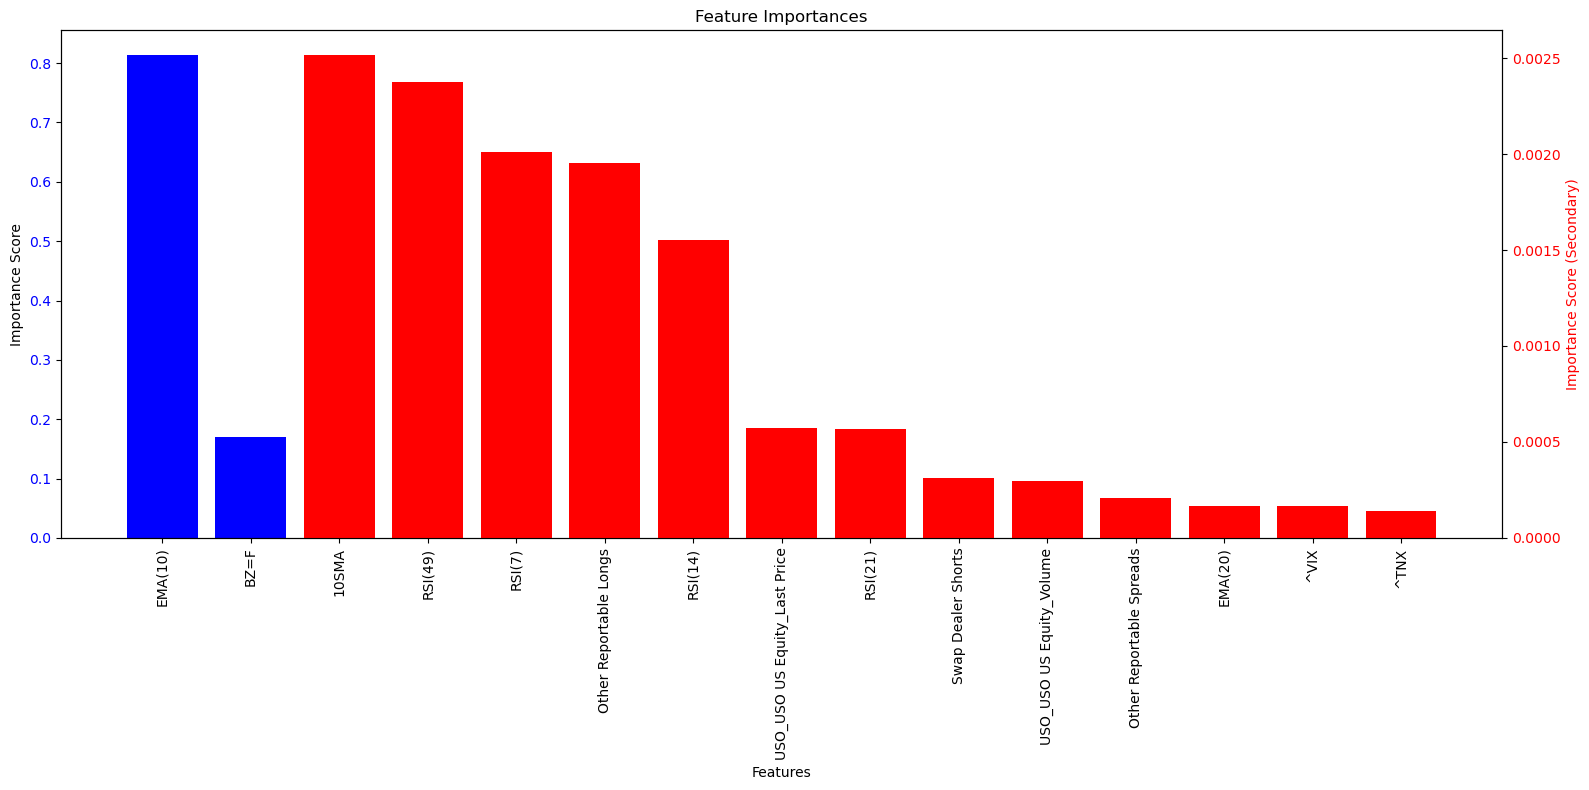

In [178]:
# Assuming you have already sorted the feature importances and selected the top features
sorted_indices = np.argsort(feature_importances)[::-1]
top_feature_indices = sorted_indices[:15]
top_feature_names = X.columns[top_feature_indices]
top_feature_scores = feature_importances[top_feature_indices]

# Splitting the features into two groups: first two and the rest
first_two_features = top_feature_scores[:2]
other_features = top_feature_scores[2:]

# Creating the figure and the primary y-axis
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.xticks(range(len(top_feature_names)), top_feature_names, rotation='vertical')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance Score')
ax1.set_title('Feature Importances')

# Creating the bar plot for the first two features on the primary y-axis
ax1.bar(range(2), first_two_features, align='center', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating the secondary y-axis for the rest of the features
ax2 = ax1.twinx()
ax2.set_ylabel('Importance Score (Secondary)', color='red')

# Creating the bar plot for the rest of the features on the secondary y-axis
ax2.bar(range(2, len(top_feature_names)), other_features, align='center', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adjusting the layout and displaying the plot
fig.tight_layout()
plt.show()

## PCA

In [103]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [104]:
X = X_selected

In [105]:
# Step 1: Standardize the data
X_standardized = (X - X.mean()) / X.std()

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

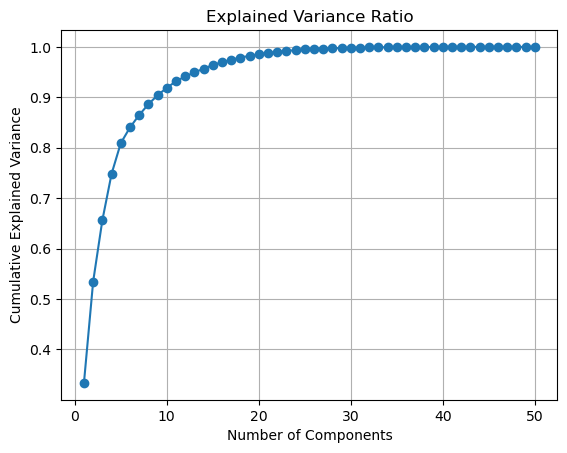

In [106]:
# Step 3: Visualize explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid(True)
plt.show()

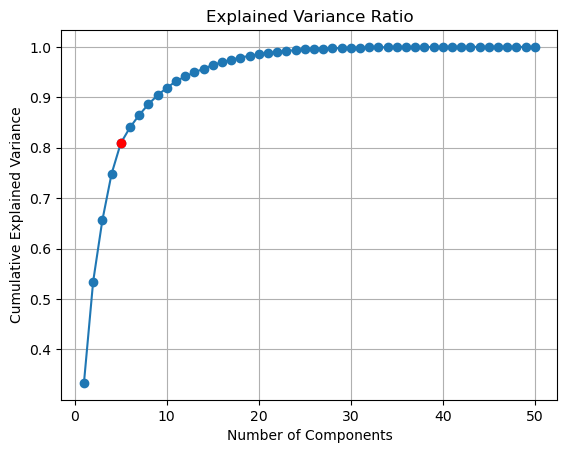

In [107]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the index where the cumulative explained variance exceeds 80%
threshold_index = np.argmax(cumulative_variance_ratio > 0.8) + 1

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.plot(threshold_index, cumulative_variance_ratio[threshold_index-1], 'ro')  # Highlight the threshold point in red
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid(True)
plt.show()


In [108]:
# Step 4: Determine the number of components to retain
# Choose the number of components that capture a significant portion of the variance (e.g., 80% or more)

# Let's assume you decide to retain 80% of the variance
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1

# Reapply PCA with the selected number of components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_standardized)

## Model building

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
import numpy as np

In [110]:
# Determine the index to split the data
split_index = int(0.8 * len(X_pca_final))

# Split the data into training and test sets
X_train = X_pca_final[:split_index]
X_test = X_pca_final[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# Verify the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1934, 5)
X_test shape: (484, 5)
y_train shape: (1934,)
y_test shape: (484,)


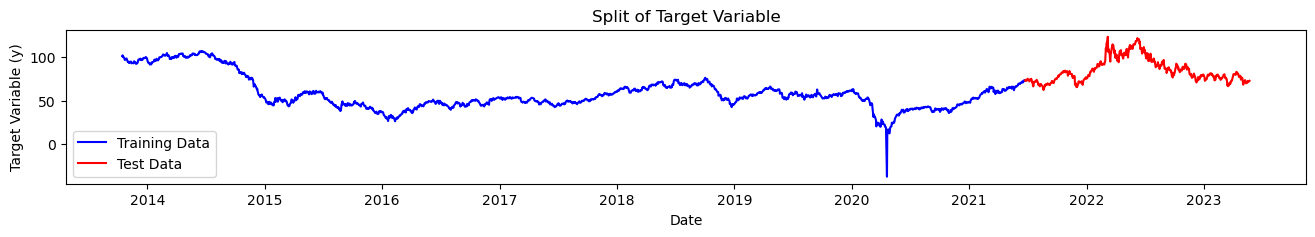

In [165]:
plt.figure(figsize=(16, 2))
plt.plot(y.index[:split_index], y_train, 'b', label='Training Data')
plt.plot(y.index[split_index:], y_test, 'r', label='Test Data')
plt.xlabel('Date')
plt.ylabel('Target Variable (y)')
plt.title('Split of Target Variable')
plt.legend()

plt.show()


In [112]:
# Random Forest
rf_model = RandomForestRegressor(random_state=2023)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=2023)

In [113]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_

In [114]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

gb_grid_search = GridSearchCV(gb_model, param_grid=gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)
gb_best_model = gb_grid_search.best_estimator_

In [115]:
# LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32)

Epoch 1/100
61/61 [==============================] - 1s 3ms/step - loss: 3494.7192
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 2237.0344
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 1759.1313
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 1456.0013
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 1220.0171
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 1030.5294
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 878.5262
Epoch 8/100
61/61 [==============================] - 0s 2ms/step - loss: 756.3748
Epoch 9/100
61/61 [==============================] - 0s 2ms/step - loss: 659.6407
Epoch 10/100
61/61 [==============================] - 0s 2ms/step - loss: 583.5697
Epoch 11/100
61/61 [==============================] - 0s 2ms/step - loss: 524.3708
Epoch 12/100
61/61 [==============================] - 0s 2ms/step - loss: 479.0885
Epoch 1

In [116]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the function to create the LSTM model
def create_lstm_model(units):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train_lstm.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the KerasRegressor wrapper for grid search
lstm_model = KerasRegressor(build_fn=create_lstm_model)

# Define the hyperparameters to tune
param_grid = {'units': [32, 64, 128],
              'epochs': [50, 100, 150],
              'batch_size': [16, 32, 64]}

# Perform grid search
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

Epoch 1/50


C:\Users\bloom\AppData\Local\Temp\ipykernel_18700\2342943496.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model)


81/81 [==============================] - 1s 2ms/step - loss: 2819.7834
Epoch 2/50
81/81 [==============================] - 0s 2ms/step - loss: 1923.0638
Epoch 3/50
81/81 [==============================] - 0s 2ms/step - loss: 1520.8042
Epoch 4/50
81/81 [==============================] - 0s 2ms/step - loss: 1295.9319
Epoch 5/50
81/81 [==============================] - 0s 2ms/step - loss: 1113.7729
Epoch 6/50
81/81 [==============================] - 0s 2ms/step - loss: 959.6810
Epoch 7/50
81/81 [==============================] - 0s 2ms/step - loss: 827.6414
Epoch 8/50
81/81 [==============================] - 0s 2ms/step - loss: 713.7771
Epoch 9/50
81/81 [==============================] - 0s 2ms/step - loss: 615.6123
Epoch 10/50
81/81 [==============================] - 0s 2ms/step - loss: 531.1873
Epoch 11/50
81/81 [==============================] - 0s 2ms/step - loss: 458.7799
Epoch 12/50
81/81 [==============================] - 0s 2ms/step - loss: 397.1613
Epoch 13/50
81/81 [============

In [117]:
# Get the best hyperparameters from grid_result
best_units = grid_result.best_params_['units']
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']

# Create the new LSTM model with best hyperparameters
lstm_best_model = Sequential()
lstm_best_model.add(LSTM(units=best_units, input_shape=(X_train_lstm.shape[1], 1)))
lstm_best_model.add(Dense(units=1))
lstm_best_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the new LSTM model with best hyperparameters
lstm_best_model.fit(X_train_lstm, y_train, epochs=best_epochs, batch_size=best_batch_size)

Epoch 1/150
61/61 [==============================] - 1s 4ms/step - loss: 2982.0195
Epoch 2/150
61/61 [==============================] - 0s 3ms/step - loss: 1392.1388
Epoch 3/150
61/61 [==============================] - 0s 3ms/step - loss: 929.9722
Epoch 4/150
61/61 [==============================] - 0s 4ms/step - loss: 668.1381
Epoch 5/150
61/61 [==============================] - 0s 3ms/step - loss: 518.4416
Epoch 6/150
61/61 [==============================] - 0s 4ms/step - loss: 436.3656
Epoch 7/150
61/61 [==============================] - 0s 3ms/step - loss: 394.6586
Epoch 8/150
61/61 [==============================] - 0s 4ms/step - loss: 370.8107
Epoch 9/150
61/61 [==============================] - 0s 3ms/step - loss: 338.9092
Epoch 10/150
61/61 [==============================] - 0s 3ms/step - loss: 298.8966
Epoch 11/150
61/61 [==============================] - 0s 3ms/step - loss: 231.3554
Epoch 12/150
61/61 [==============================] - 0s 3ms/step - loss: 187.6401
Epoch 13/15

In [118]:
# SVM
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

SVR()

In [119]:
# Simple Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [146]:
# Evaluate models
rf_pred = rf_best_model.predict(X_test)
gb_pred = gb_best_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test_lstm)
svm_pred = svm_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

16/16 [==============================] - 0s 2ms/step


In [147]:
# Calculate RMSE for each model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_pred))
lr_rmse = np.sqrt(mean_squared_error(y_test,lr_pred))

In [148]:
print("Random Forest RMSE:", rf_rmse)
print("Gradient Boosting RMSE:", gb_rmse)
print("LSTM RMSE:", lstm_rmse)
print("SVM RMSE:", svm_rmse)
print("Linear Regression RMSE:", lr_rmse)

Random Forest RMSE: 26.673650254495314
Gradient Boosting RMSE: 22.808767527930307
LSTM RMSE: 14.021432369599086
SVM RMSE: 24.850175425459344
Linear Regression RMSE: 8.153220780523073


In [149]:
from sklearn.metrics import mean_absolute_error

mae_rf = mean_absolute_error(y_test, rf_pred)
mae_gb = mean_absolute_error(y_test, gb_pred)
mae_lstm = mean_absolute_error(y_test, lstm_pred)
mae_svm = mean_absolute_error(y_test, svm_pred)
mae_lr = mean_absolute_error(y_test, lr_pred)


In [150]:
from sklearn.metrics import explained_variance_score

evs_rf = explained_variance_score(y_test, rf_pred)
evs_gb = explained_variance_score(y_test, gb_pred)
evs_lstm = explained_variance_score(y_test, lstm_pred)
evs_svm = explained_variance_score(y_test, svm_pred)
evs_lr = explained_variance_score(y_test, lr_pred)


In [151]:
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, rf_pred)
r2_gb = r2_score(y_test, gb_pred)
r2_lstm = r2_score(y_test, lstm_pred)
r2_svm = r2_score(y_test, svm_pred)
r2_lr = r2_score(y_test, lr_pred)

In [152]:
print("Random Forest:")
print("RMSE:", rf_rmse)
print("MAE:", mae_rf)
print("R2 Score:", r2_rf)
print("Explained Variance Score:", evs_rf)

print("\nGradient Boosting:")
print("RMSE:", gb_rmse)
print("MAE:", mae_gb)
print("R2 Score:", r2_gb)
print("Explained Variance Score:", evs_gb)

print("\nLSTM:")
print("RMSE:", lstm_rmse)
print("MAE:", mae_lstm)
print("R2 Score:", r2_lstm)
print("Explained Variance Score:", evs_lstm)

print("\nSVM:")
print("RMSE:", svm_rmse)
print("MAE:", mae_svm)
print("R2 Score:", r2_svm)
print("Explained Variance Score:", evs_svm)

print("\nLinear Regression:")
print("RMSE:", lr_rmse)
print("MAE:", mae_lr)
print("R2 Score:", r2_lr)
print("Explained Variance Score:", evs_lr)


Random Forest:
RMSE: 26.673650254495314
MAE: 23.53915737974939
R2 Score: -2.7837366606567286
Explained Variance Score: 0.16297623157820662

Gradient Boosting:
RMSE: 22.808767527930307
MAE: 19.868431205525486
R2 Score: -1.7666844916413433
Explained Variance Score: 0.3326573029430169

LSTM:
RMSE: 14.021432369599086
MAE: 11.122765478023814
R2 Score: -0.04554026152207258
Explained Variance Score: 0.24121823716143886

SVM:
RMSE: 24.850175425459344
MAE: 20.918026827923395
R2 Score: -2.284088983108588
Explained Variance Score: 0.042916622151786044

Linear Regression:
RMSE: 8.153220780523073
MAE: 5.528949600217972
R2 Score: 0.6464796622070579
Explained Variance Score: 0.804264800808258


76/76 [==============================] - 0s 1ms/step


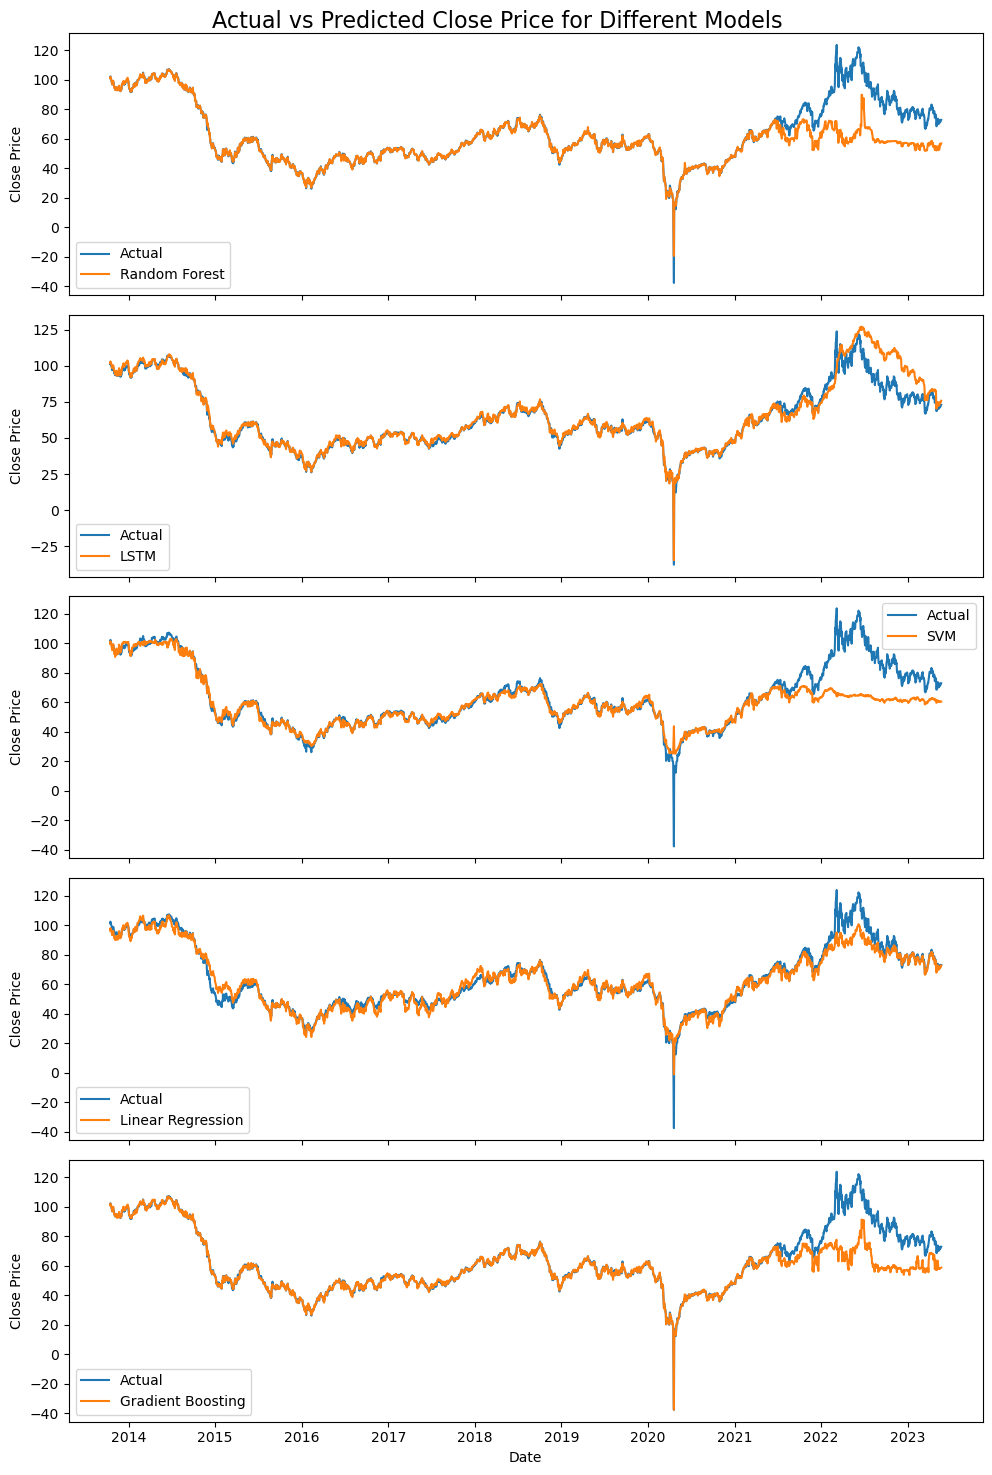

In [145]:
# Predict on the entire dataset for all models
rf_pred_all = rf_best_model.predict(X_pca_final)
lstm_pred_all = lstm_model.predict(np.reshape(X_pca_final, (X_pca_final.shape[0], X_pca_final.shape[1], 1)))
svm_pred_all = svm_model.predict(X_pca_final)
lr_pred_all = lr_model.predict(X_pca_final)
gb_pred_all = gb_best_model.predict(X_pca_final)

# Create a list of the predicted values for each model
pred_list = [rf_pred_all, lstm_pred_all, svm_pred_all, lr_pred_all,gb_pred_all]

# Create a list of the model names
model_names = ['Random Forest', 'LSTM', 'SVM', 'Linear Regression', 'Gradient Boosting']

# Create subplots with 5 rows and 1 column
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# Loop through each model's predictions and plot in separate subplots
for i in range(len(pred_list)):
    ax = axes[i]
    ax.plot(y.index, y, label='Actual')
    ax.plot(y.index, pred_list[i], label=model_names[i])
    ax.legend()
    ax.set_ylabel('Close Price')

# Set common x-axis label and title for the entire figure
plt.xlabel('Date')
plt.suptitle('Actual vs Predicted Close Price for Different Models', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Display the combined graph
plt.show()


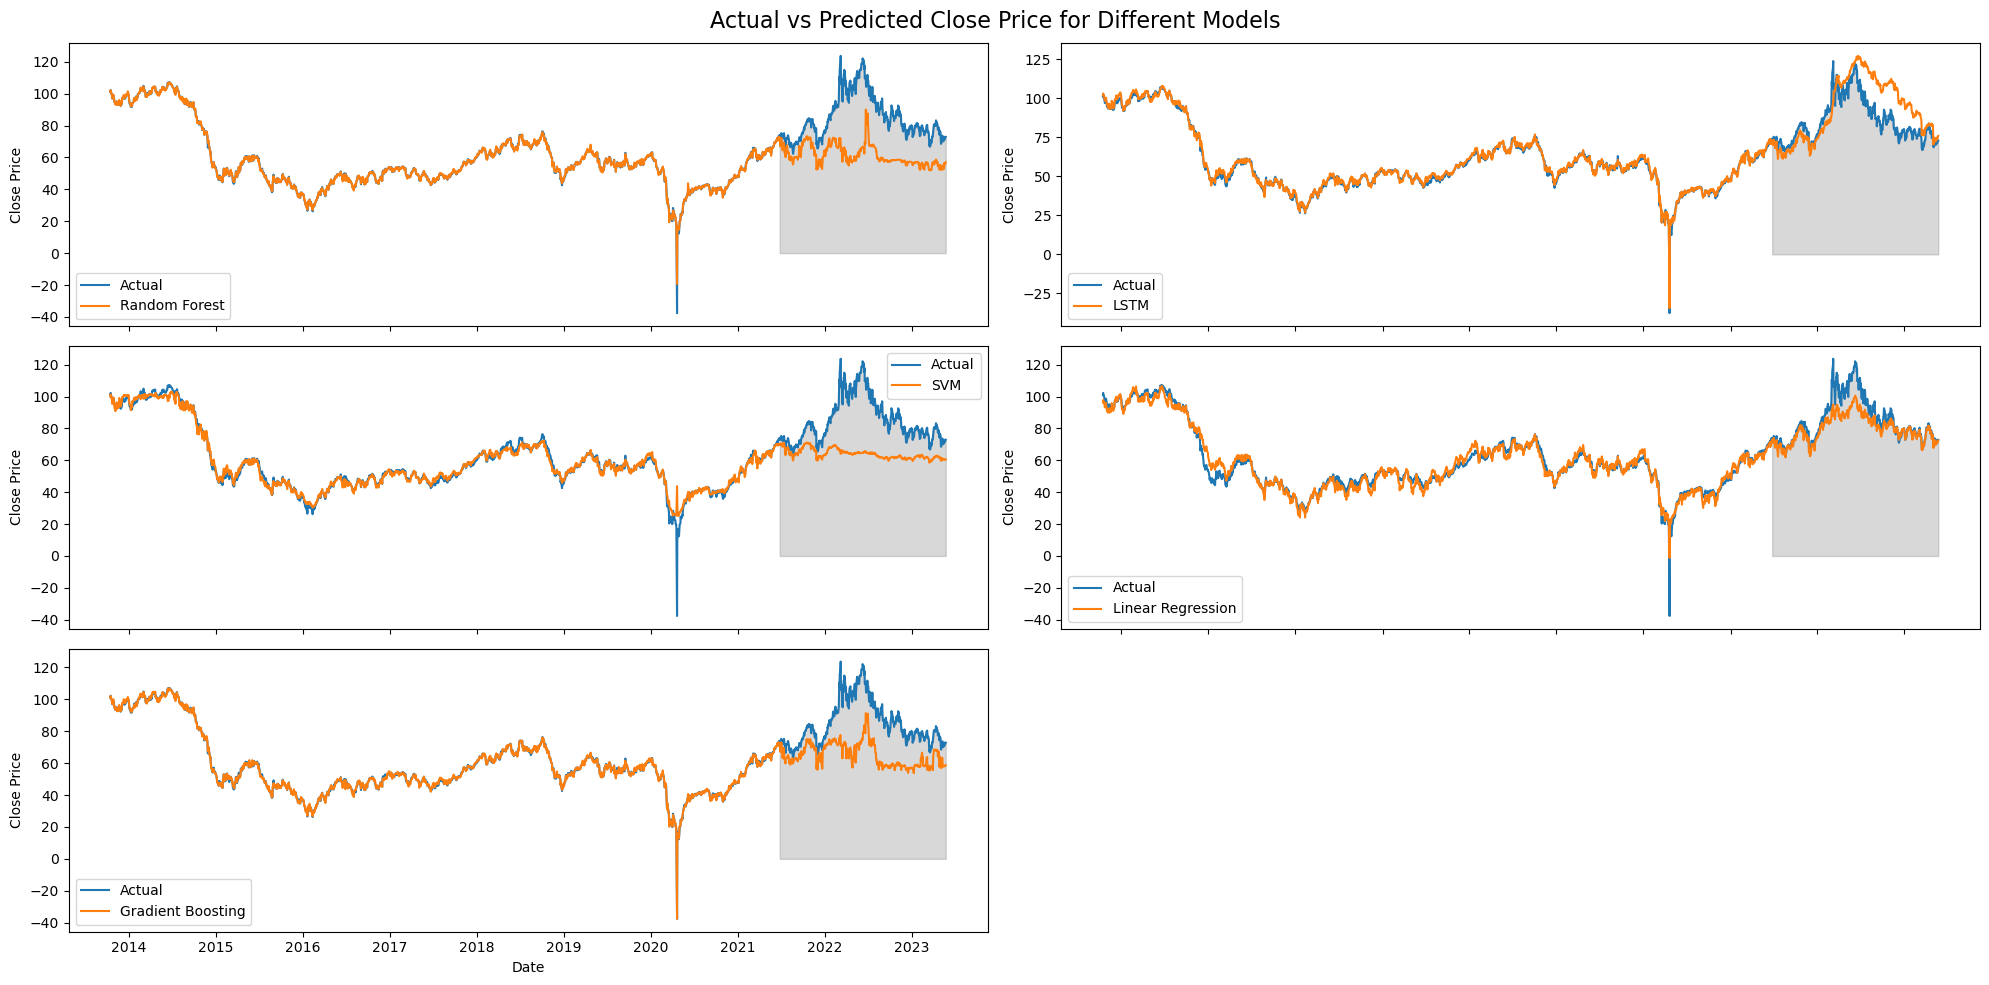

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the index range for the last 20% of the data
last_20_percent = int(len(y) * 0.2)
start_index = len(y) - last_20_percent

fig, axes = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i in range(len(pred_list)):
    ax = axes[i]
    ax.plot(y.index, y, label='Actual')  # Assuming 'Close' is the column name for the actual values
    ax.plot(y.index, pred_list[i], label=model_names[i])
    
    # Add shadow to the last 20% of the plot area
    ax.fill_between(y.index[start_index:], 0, y[start_index:], color='gray', alpha=0.3)
    
    ax.legend()
    ax.set_ylabel('Close Price')

fig.delaxes(axes[-1])

plt.xlabel('Date')
plt.suptitle('Actual vs Predicted Close Price for Different Models', fontsize=16)
plt.tight_layout()
plt.show()


## Implement cross-validation

In [128]:
## Model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
import numpy as np

In [129]:

# Split the data into train and test sets
X_train = X_pca_final[:split_index]
X_test = X_pca_final[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
# Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse_cv = np.sqrt(-rf_cv_scores.mean())

# Train the model
rf_model.fit(X_train, y_train)

# Hyperparameter tuning for Random Forest
# You can adjust the parameter grid and search space according to your needs
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_

In [130]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Perform cross-validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
gb_rmse_cv = np.sqrt(-gb_cv_scores.mean())

# Train the model
gb_model.fit(X_train, y_train)

# Hyperparameter tuning for Gradient Boosting
# You can adjust the parameter grid and search space according to your needs
gb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

gb_grid_search = GridSearchCV(gb_model, param_grid=gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)
gb_best_model = gb_grid_search.best_estimator_

In [139]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Define TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
lstm_cv_scores = []
for train_index, val_index in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    lstm_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    mse = lstm_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    lstm_cv_scores.append(mse)

# Calculate root mean squared error (RMSE) from the mean of the cross-validation scores
lstm_rmse_cv = np.sqrt(np.mean(lstm_cv_scores))

# Train the model on the entire training data
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32)



Epoch 1/100
61/61 [==============================] - 0s 2ms/step - loss: 27.9655
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 9.2826
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 7.2024
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 6.5468
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 5.7337
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 5.7949
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 5.5020
Epoch 8/100
61/61 [==============================] - 0s 2ms/step - loss: 5.0703
Epoch 9/100
61/61 [==============================] - 0s 2ms/step - loss: 4.7022
Epoch 10/100
61/61 [==============================] - 0s 2ms/step - loss: 4.5338
Epoch 11/100
61/61 [==============================] - 0s 2ms/step - loss: 4.7285
Epoch 12/100
61/61 [==============================] - 0s 2ms/step - loss: 3.9893
Epoch 13/100
61/61 [================

In [134]:
# SVM
svm_model = SVR(kernel='rbf')

# Perform cross-validation for SVM
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
svm_rmse_cv = np.sqrt(-svm_cv_scores.mean())

# Train the model
svm_model.fit(X_train, y_train)

# Hyperparameter tuning for SVM
# You can adjust the parameter grid and search space according to your needs
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10]
}

svm_grid_search = GridSearchCV(svm_model, param_grid=svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)
svm_best_model = svm_grid_search.best_estimator_

In [135]:
# Evaluate models on the test set
rf_predictions = rf_best_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

gb_predictions = gb_best_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))

lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = np.reshape(lstm_predictions, (lstm_predictions.shape[0],))
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

svm_predictions = svm_best_model.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))

16/16 [==============================] - 0s 1ms/step


In [140]:

# Print the RMSE scores
print("Random Forest RMSE (Cross-Validated):", rf_rmse_cv)
print("Random Forest RMSE (Test Set):", rf_rmse)
print("Gradient Boosting RMSE (Cross-Validated):", gb_rmse_cv)
print("Gradient Boosting RMSE (Test Set):", gb_rmse)
print("LSTM RMSE (Cross-Validated):", lstm_rmse_cv)
print("LSTM RMSE (Test Set):", lstm_rmse)
print("SVM RMSE (Cross-Validated):", svm_rmse_cv)
print("SVM RMSE (Test Set):", svm_rmse)


Random Forest RMSE (Cross-Validated): 17.61862903622139
Random Forest RMSE (Test Set): 26.673650254495314
Gradient Boosting RMSE (Cross-Validated): 15.759527877032815
Gradient Boosting RMSE (Test Set): 22.808767527930307
LSTM RMSE (Cross-Validated): 21.373476623325335
LSTM RMSE (Test Set): 5.053184274623677
SVM RMSE (Cross-Validated): 19.658087401728224
SVM RMSE (Test Set): 32.28016742179964


In [137]:
# Generate Trading Signals
gb_predictions = gb_best_model.predict(X_test)
trading_signals = np.where(gb_predictions > 0, 1, -1)

# Calculate Returns
returns = trading_signals * y_test  # Assuming y_test represents the actual returns of the stock

# Calculate Sharpe Ratio
risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
daily_returns = returns
sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

# Annualize the Sharpe Ratio (optional)
sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)  # Assuming 252 trading days in a year

# Print the Sharpe Ratio
print("Sharpe Ratio:", sharpe_ratio)
print("Annualized Sharpe Ratio:", sharpe_ratio_annualized)

Sharpe Ratio: 6.195168272240315
Annualized Sharpe Ratio: 98.34524747127342


In [138]:
def sharpe_ratio(ts_returns, periods_per_year=252, riskfree_rate=0.02):
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = (annualized_return - riskfree_rate) / annualized_vol
    return annualized_return, annualized_vol, annualized_sharpe

rf_predictions = rf_best_model.predict(X_test)
trading_signals = np.where(rf_predictions > 0, 1, -1)
returns = trading_signals * y_test

sharpe_ratio_annualized = sharpe_ratio(returns)[2]  # Using the annualized Sharpe ratio from the function

print("Annualized Sharpe Ratio:", sharpe_ratio_annualized)


Annualized Sharpe Ratio: inf
